## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%run utils.ipynb import *

## Preprocess Data

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("C:/Users/mahmo/Desktop/Identify-Customer-Segments/input/Udacity_AZDIAS_Subset.csv",delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("C:/Users/mahmo/Desktop/Identify-Customer-Segments/input/AZDIAS_Feature_Summary.csv",delimiter=";")

In [3]:
cleaner = DataCleaner()
feat_info = cleaner.clean_feature_info(feat_info)
second_subset = cleaner.clean_general_data(azdias, feat_info)

Removed Columns are: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


## Feature Transformation

In [4]:
# tranform features
transformer = FeatureTransformer()
second_subset = transformer.sclae_data(second_subset, feat_info)
azdias_pca = transformer.reduce_dims(second_subset)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In [5]:
# Over a number of different cluster counts run k-means clustering on the data and
# compute the average within-cluster distances.
clusters  = np.arange(10,42,2)
inertias = []
for k in clusters :
    kmeans = KMeans(k, n_init=10)
    kmeans.fit(azdias_pca)
    inertias.append(kmeans.inertia_)

Text(0, 0.5, 'Inertia')

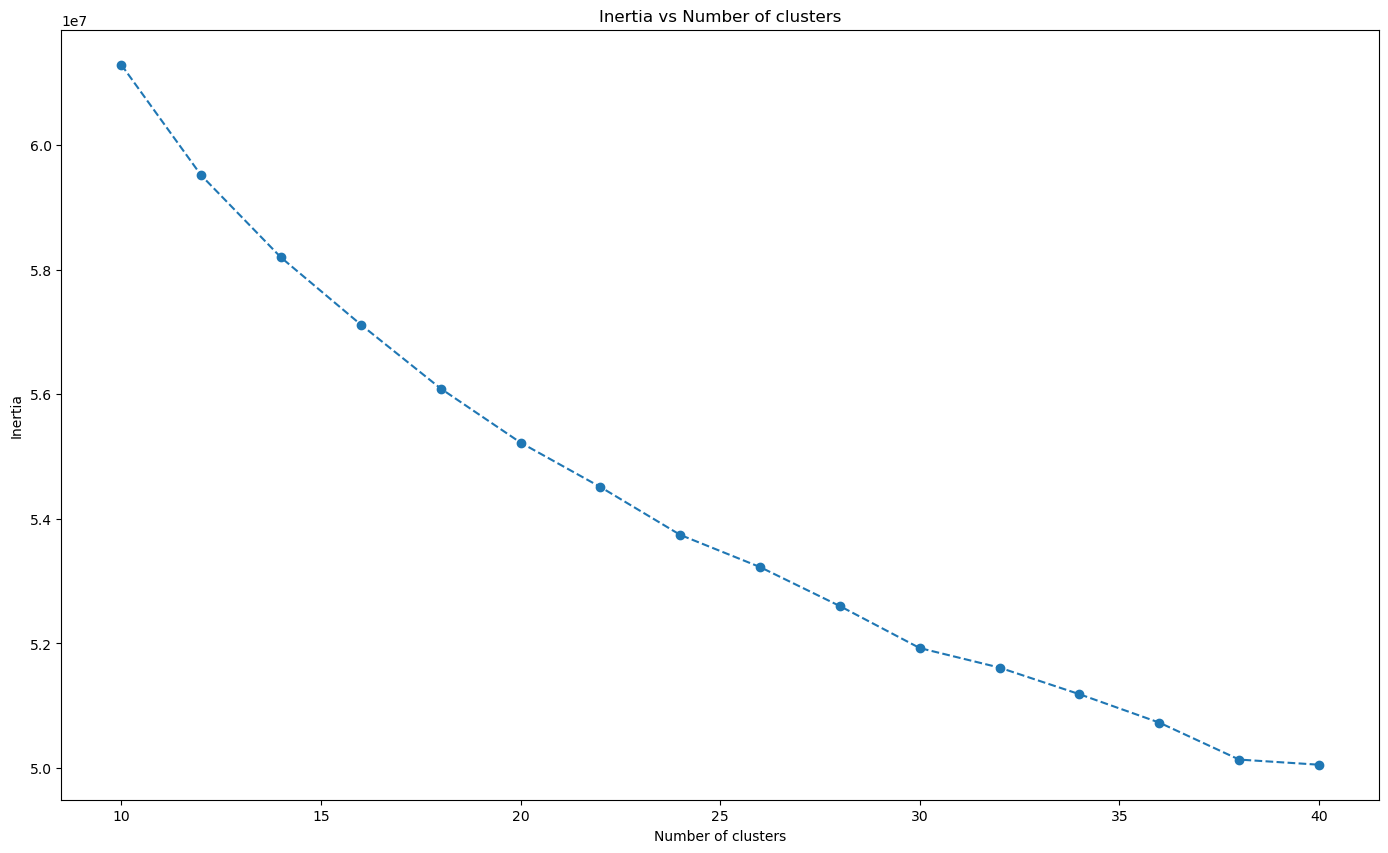

In [6]:
# Investigate the change in within-cluster distance across number of clusters.
plt.figure(figsize=(17,10))
plt.title("Inertia vs Number of clusters")
plt.plot(clusters, inertias, marker='o', linestyle="--")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

In [5]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters= 28, n_init=10)
kmeans.fit(azdias_pca)

KMeans(n_clusters=28, n_init=10)

In [6]:
# predict clusters labels
azdias_pred = kmeans.predict(azdias_pca)

After applying the elbow method on the k-means clustering of the dataset, I have chosen the optimal number of clusters to be **28**. This decision was made by analyzing the plot of the within-cluster distances versus the number of clusters. The "elbow" point on the plot, where the rate of decrease in within-cluster distances begins to level off, was determined to be at **28** clusters. This suggests that adding more clusters beyond this point would not greatly decrease the within-cluster distances and therefore, **28** clusters was chosen as the optimal number.

### Step 3.2: Apply All Steps to the Customer Data

In [7]:
# Load in the customer demographics data.
customers = pd.read_csv("C:/Users/mahmo/Desktop/Identify-Customer-Segments/input/Udacity_CUSTOMERS_Subset.csv",delimiter=";")

In [8]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = cleaner.clean_customer_data(customers, feat_info)

Removed Columns are: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [9]:
# scaling the data
scaled_numerical_columns = transformer.scalar.transform(customers_cleaned[transformer.numerical_cols])
scaled_numerical_columns = pd.DataFrame(scaled_numerical_columns, index=customers_cleaned.index, columns=transformer.numerical_cols)
customers_cleaned = customers_cleaned.drop(columns=transformer.numerical_cols)
customers_scaled = pd.concat([customers_cleaned, scaled_numerical_columns], axis=1)

In [10]:
# dimensionality reduction
customers_pca = transformer.pca.transform(customers_scaled)

In [11]:
# predict clusters labels
customers_pred = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

We will consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

We will take a look at the following points in this step:

- Which cluster or clusters are overrepresented in the customer dataset compared to the general population?
- Similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [12]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_pred_df = pd.DataFrame(azdias_pred,columns=["Cluster"])
customers_pred_df = pd.DataFrame(customers_pred,columns=["Cluster"])

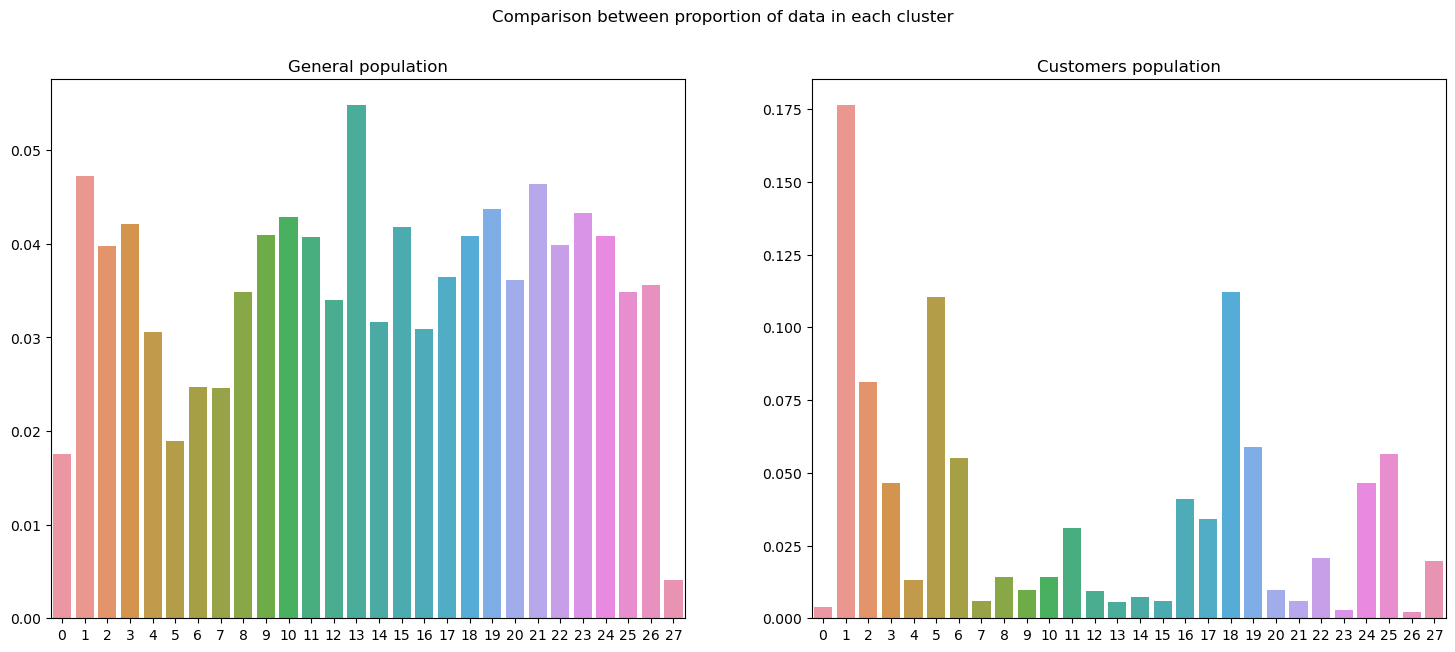

In [13]:
data_count = DataCountVisualizer()
data_count.proportion_plot(azdias_pred_df, customers_pred_df, 'Cluster', 'Comparison between proportion of data in each cluster ',
         'General population', 'Customers population')

In [15]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster = Cluster(kmeans=kmeans, transformer=transformer, customers_scaled=customers_scaled)
overrepresented = cluster.get_cluster_info(5)

In [16]:
overrepresented

,Cluster 5
ANREDE_KZ,0.941486
SOHO_KZ,0.009234
VERS_TYP,1.101914
OST_WEST_KZ,0.135291
WOHNLAGE,2.992780
...,...
MIN_GEBAEUDEJAHR,1992.645360
ANZ_PERSONEN,1.847426
ANZ_TITEL,0.000151
ANZ_HH_TITEL,0.016294


In [17]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented = cluster.get_cluster_info(26)

In [18]:
underrepresented

,Cluster 26
ANREDE_KZ,0.958381
SOHO_KZ,0.008500
VERS_TYP,1.527328
OST_WEST_KZ,0.249290
WOHNLAGE,3.669332
...,...
MIN_GEBAEUDEJAHR,1992.610861
ANZ_PERSONEN,1.468120
ANZ_TITEL,-0.000045
ANZ_HH_TITEL,0.026626


From the anaylsis above, it can be seen that

**Cluster 5** is overrepresented in the customers data compared to general population data. Some characteristics of the group of population that are relative popular with the mail-order company:

- in areas where gender is male (ANREDE_KZ = 0.941486).
- in areas where Neighborhood quality is average neighborhood (WOHNLAGE =  2.992780).
- in areas where Small office / home office flag is no small office/home office (SOHO_KZ = 0.009234)

**Cluster 26** is underrepresented in the customers data. Some characteristics of the segment of the population that are relatively unpopular with the company:

- in areas where gender is female (ANREDE_KZ = 0.958381).
- in areas where Insurance typology is individualistic-accepting risks (VERS_TYP = 1.527328).
- in areas where Neighborhood quality is poor neighborhood (WOHNLAGE =  3.669332).